In [1]:
import rasterstats
from rasterstats import zonal_stats
import rasterio
import rioxarray as rxr
from rasterio.plot import show
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
spatial_path = "/Users/markos98/aquasteady_research/data/spatial/"
shape_path = "/Users/markos98/aquasteady_research/data/spatial/shapefiles/"

In [3]:
with rasterio.open(spatial_path + "california.tif") as src:
    spi_data = src.read(1)  
    bounds = src.bounds     
    crs = src.crs

In [4]:
CA_watersheds = gpd.read_file(shape_path + "WBDHU6.shp")
CA_watersheds = watersheds.to_crs(crs)  # Match CRS to SPI data

KeyError: 'Irrigated_Acres'

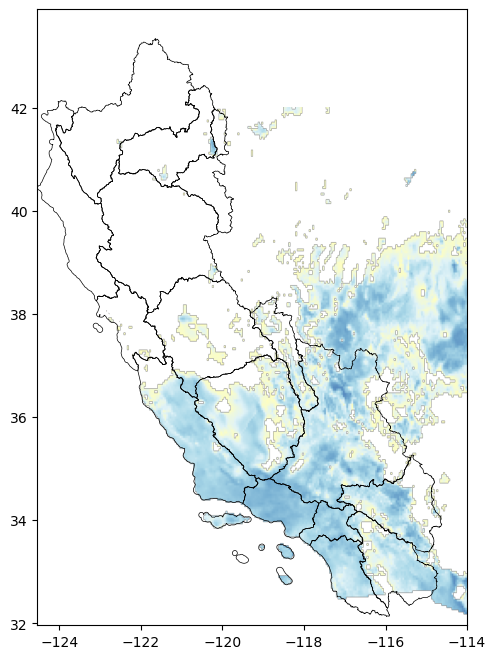

In [5]:
fig, ax = plt.subplots(figsize=(12, 8))

# Plot SPI raster
show(spi_data, ax=ax, transform=src.transform, cmap="RdYlBu", vmin=-3, vmax=3)

# Overlay watershed boundaries
watersheds.boundary.plot(ax=ax, linewidth=0.5, color="black")

# Add USDA irrigation data (if available)
# Example: Color watersheds by irrigation acres
watersheds.plot(ax=ax, column="Irrigated_Acres", legend=True, alpha=0.3)

plt.colorbar(label="SPI (Drier < 0 | Wetter > 0)")
plt.title("SPI vs. USDA Irrigation Challenges")
plt.show()

In [3]:
tif_path = spatial_path + "california.tif"  # Replace with your filename
watershed_path = shape_path + "WBDHU6.shp"  # Path to watershed shapefile

In [4]:
stats = zonal_stats(
    watershed_path,  
    tif_path,        
    stats=["mean", "median", "min", "max"]  
)

print(stats)

/Volumes/Mac/opt/anaconda3/envs/aquasteady/lib/python3.13/site-packages/rasterstats/io.py:335: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


[{'min': 0.0072618533892532255, 'max': 1.7034168334998248, 'mean': 1.0471713181119533, 'median': 1.1199097366157778}, {'min': 0.0010223095157748663, 'max': 0.9736593665884697, 'mean': 0.3553226047943125, 'median': 0.2754921921452237}, {'min': 0.2764947704910785, 'max': 1.6936238445705596, 'mean': 1.0870903562745633, 'median': 1.1065739137087}, {'min': 0.0, 'max': 0.0, 'mean': 0.0, 'median': 0.0}, {'min': 0.841767441999322, 'max': 1.8959601239548327, 'mean': 1.5040410359360632, 'median': 1.5528040770536449}, {'min': 0.005114169765971344, 'max': 1.35245248048709, 'mean': 0.49052300801055465, 'median': 0.44156711835123574}, {'min': 7.351718001258334e-05, 'max': 0.34650147789510677, 'mean': 0.10015229220432945, 'median': 0.06954685743244338}, {'min': 0.0, 'max': 1.7463897521895748, 'mean': 0.2256765597768939, 'median': 0.0}, {'min': 0.3247246386181568, 'max': 1.8289422697609847, 'mean': 1.228704722381409, 'median': 1.2397142994600532}, {'min': 0.0015460207467525855, 'max': 1.62960195090199